In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use('ggplot')
import json
import re
from itertools import chain, groupby
from collections import OrderedDict, defaultdict, Counter

import numpy as np
from pandas import DataFrame

In [2]:
def parse_jl(filepath):
    with open(filepath) as f:
        return [json.loads(line) for line in f]
autoevolution = parse_jl('autoevolution.jl')
for car in autoevolution:
    car['model'] = car['title'][len(car['brand']):].strip()
    car['start_year'] = car['years'].split('-')[0].strip()
    try:
        end_year = car['years'].split('-')[-1].strip()
        car['end_year'] = int(end_year)
    except ValueError:
        car['end_year'] = 2017
carsireland = parse_jl('carsireland.jl')
donedeal = parse_jl('donedeal.jl')

In [3]:
def clean_make(car):
    make = car['Make']
    if make is None:
        return
    make = make.upper()
    if make.endswith('CAR'):
        make = make[:len('CAR')]
    return make
    
def clean_model(car):
    make, model = car['Make'], car['Model']
    if model is None:
        return
    model = model.upper()
    model =  (model.replace(make, '').replace(' ', '').replace('-', '')
                   .replace('SERIES', '').replace('CLASS', '').replace('PININ', '')
                   .split('/')[0].strip())
    if not model or model in (u'', u'NONE', u'MODELUNKNOWN'):
        return None
    return model

_YEARS_RE = re.compile('(1[34567][12])\)?$')
def clean_year(car):
    year_str = car['Year']
    if isinstance(year_str, (int, float)):
        return year_str
    if not year_str:
        return None
    m = _YEARS_RE.search(year_str) 
    if m:
        year_str = m.groups()[0]
        year = int('20' + year_str[:-1])
        if year_str.endswith('2'):
            year += 0.5
    else:
        year = int(year_str)
    if not (1900 < year < 2018):
        return None
    car['Year'] = year
    return year

def clean_mileage(car):
    mileage = car.get('Mileage', car.get('Odometer'))
    if not mileage:
        return None
    if isinstance(mileage, (int, float)):
        return mileage
    try:
        distance, unit = mileage.split()[:2]
    except ValueError:
        try:
            distance, unit = str(int(mileage)), 'km'
        except ValueError:
            return None
    distance = int(distance.replace(',', ''))
    if distance < 1000 and car['Year'] < 2016:
        distance *= 10
    if distance < 10000 and car['Year'] < 2015:
        distance *= 10
    if unit.lower().startswith('mi'):
        distance *= 1.609
    if distance < 10000 and car['Year'] < 2010:
        distance *= 10
    if distance > 100000000:
        distance /= 1000
    if distance > 700000:
        if car['Year'] > 2004:
            return int(distance / 10)
        return None
    return int(distance)

body_type_map = {
    '00': None, '': None, 'PLEASE SELECT...': None, 'OTHER': None, 'CABRIOLET': 'CONVERTIBLE',
    '4X4/SUV': 'SUV', 'CREW CAB': 'PICKUP', 'DOUBLE CAB PICKUP': 'PICKUP', 'ESTATE/JEEP': 'SUV',
    'SPORTS/COUPE(NON CONVERTIBLE)': 'COUPE', 'LIFTBACK': 'HATCHBACK', 'REFRIGERATED VAN': 'VAN',
    'WHEELCHAIR ACCESSIBLE': 'MPV', 'CAMPER': 'VAN', 'CABRIO': 'CABRIOLET', 'ROADSTER': 'CABRIOLET',
    'FREESTYLE CAB': 'PICKUP', 'ACCESS CAB': 'PICKUP', 'CLUB CAB': 'PICKUP', 'CREW CAB': 'PICKUP',
    'DOUBLE CAB': 'PICKUP', 'EXTENDED CAB': 'PICKUP', 'EXTRA CAB': 'PICKUP', 'FRONTIER DOUBLE CAB': 'PICKUP',
    'FRONTIER KING CAB': 'PICKUP', 'HD CREW CAB': 'PICKUP', 'HD DOUBLE CAB': 'PICKUP',
    'HD REGULAR CAB': 'PICKUP', 'KING CAB': 'PICKUP', 'MEGA CAB': 'PICKUP', 'PICKUP DOUBLE CAB': 'PICKUP',
    'PICKUP KING CAB': 'PICKUP', 'PICKUP SINGLE CAB': 'PICKUP', 'QUAD CAB': 'PICKUP',
    'REGULAR CAB': 'PICKUP', 'SINGLE CAB': 'PICKUP', 'SUPER CAB': 'PICKUP', 'PICK-UP': 'PICKUP',
    'SEDAN': 'SALOON', 'TARGA': 'CABRIOLET', 'SUPER CREW': 'PICKUP', 'STATION WAGON': 'SUV',
    'MULTI WAGON': 'SUV', 'KOMBI': 'VAN'
}
def clean_body(car):
    body = car.get('Body type') or car.get('Body')
    if not body:
        return None
    body = body.upper()
    return body_type_map.get(body, body)
  
_PRICE_SUB = re.compile('[^0-9]').sub
GBP_to_EUR = 1.11
def clean_price(car):
    price = car.get('price') or car.get('Price')
    if not price:
        return None
    if not isinstance(price, basestring):
        return price
    currency = car.get('currency') or u'EUR'
    if price[0] == u'£':
        currency = u'GBP'
    try:
        price = int(_PRICE_SUB('', price))
    except ValueError:
        return None
    if currency == u'GBP':
        price *= GBP_to_EUR
    return price
    

counties = {u'ANTRIM', u'ARMAGH', u'CARLOW', u'CAVAN', u'CLARE', u'CORK',
            u'DERRY', u'DONEGAL', u'DOWN', u'DUBLIN', u'FERMANAGH', u'GALWAY',
            u'KERRY', u'KILDARE', u'KILKENNY', u'LAOIS', u'LEITRIM', u'LIMERICK',
            u'LONGFORD', u'LOUTH', u'MAYO', u'MEATH', u'MONAGHAN', u'OFFALY',
            u'ROSCOMMON', u'SLIGO', u'TIPPERARY', u'TYRONE', u'WATERFORD',
            u'WESTMEATH', u'WEXFORD', u'WICKLOW'}
def _county_from_address(address):
    return address.upper().replace('CO.', '').replace('LOCATION:', '').strip().split()[0]
def clean_county(car):
    if 'county' in car and car['county'] in counties:
        return car['county']
    county =  car.get('county') or car.get('seller')
    if isinstance(county, dict):
        pos = -1
        address = county.get('address')
        county = _county_from_address(address[pos])
        while county and county not in counties:
            pos -= 1
            county = _county_from_address(address[pos])
    return county.upper().replace('CO.', '').strip()

def clean_engine(car):
    engine = car.get('Engine size')
    if not engine:
        return None
    try:
        engine_size = float(engine.split()[0])
        if engine_size >= 1000:
            engine_size /= 1000
        if engine_size >= 100:
            engine_size /= 100
        if engine_size > 6.8:
            engine_size /= 10
        return engine_size
    except ValueError:
        if engine.upper() == 'UNDER 1.0':
            return 0.9
        return None

fuels = {'00': None, 'OTHER': None, 'ETHANOL/PETROL': 'PETROL'}
def clean_fuel_system(car):
    fuel = car.get('Fuel type')
    if not fuel:
        return None
    fuel = fuel.upper()
    return fuels.get(fuel, fuel)

class DataObject(object):
    properties = []

    @property
    def _tuple(self):
        return tuple(getattr(self, k) for k in self.properties)

    def __hash__(self):
        return hash(str(self))
    
    def __repr__(self):
        return'{}({})'.format(self.__class__.__name__, str(self))
    
    def __str__(self):
        return ', '.join('{}={!r}'.format(k, getattr(self, k)) for k in self.properties)

class Seller(DataObject):
    properties = ('name', 'address', 'type', 'phones', 'website')
    def __init__(self, name, address, type, phones, website):
        self.name, self.address, self.type, self.phones, self.website = (
            name, ', '.join(address), type, ', '.join(phones), website
        )


_COUNTY_RE = re.compile('co\.?\s', re.I).sub
_DUBLIN_RE = re.compile('d\d+', re.I).sub
seller_stopwords = {u'&',
                    u' AND',
                    u'AUTO',
                    u'AUTOS',
                    u' CAR',
                    u'CARS',
                    u'CENTRE',
                    u'COMPANY',
                    u'GARAGE',
                    u'LIMITED',
                    u'LTD',
                    u'LTD.',
                    u'MOTOR',
                    u'MOTORS',
                    u'OF',
                    u'ROAD',
                    u'SALES',
                    u'SERVICES',
                    u'SONS',
                    u'TRADE'}
def clean_seller(car):
    meta = car
    seller = car.get('seller', {})
    address = seller.get('address', '') or meta.get('address', '').split(',')
    address = [_COUNTY_RE('', s.strip())
               for s in address if s and s.strip()]
    name = seller.get('name') or meta.get('publishedName')
    if name:
        name = name.upper()
        original_name = name
        name = _DUBLIN_RE('', name)
        for stopword in seller_stopwords:
            name = name.replace(stopword, '')
        name = name.strip()
    type_ = seller.get('type')
    if address and address[-1].startswith('Location:'):
        name = address[0].split(' ', 1)[0]
        address = [address[-1].split(' ')[-1].title()]
        type_ = 'PRIVATE'
    if not address:
        address = [meta.get('county').title()]
    town = seller.get('countyTown')
    if len(address) == 1 and town:
        address.insert(0, town)
    if not name and any(s in address[0].lower() for s in ('sales', 'motor', 'ltd')):
        name, address = address[0], address[1:]
    numbers = seller.get('numbers', []) or meta.get('publisherPhoneEnc', [])
    website = seller.get('website') or meta.get('websiteURL') or ''
    if not website or len(website) != len(website.replace(' ', '')):
        website = None
    if website is not None and '://' in website:
        website = website.split('://')[-1]
    if not isinstance(numbers, list):
        numbers = [numbers]
    if type_ is None:
        type_ = 'DEALER'
    return Seller(name, address, type_, numbers, website)


def clean(car):
    return (clean_make(car), clean_model(car), clean_year(car), clean_county(car),
             clean_mileage(car), clean_body(car), clean_engine(car), clean_fuel_system(car),
             clean_price(car))

class IncrementingDict(dict):
    def __init__(self, *args, **kwargs):
        self.count = len(args) + len(kwargs)
        dict.__init__(self, *args, **kwargs)
    def __getitem__(self, key):
        if key in self:
            return dict.__getitem__(self, key)
        self[key] = self.count
        self.count += 1
        return self[key]
        

class Car(DataObject):
    counties = IncrementingDict()
    bodies = IncrementingDict([(None, 0)])
    fuels = IncrementingDict([(None, 0)])
    makes = IncrementingDict([(None, 0)])
    models = IncrementingDict([(None, 0)])
    properties = OrderedDict((
            ('make', clean_make), ('model', clean_model), ('year', clean_year),
            ('county', clean_county), ('odometer', clean_mileage), ('body', clean_body), 
            ('engine', clean_engine), ('fuel',  clean_fuel_system), ('price', clean_price)))
    def __init__(self, car):
        for k, v in zip(self.properties, clean(car)):
            setattr(self, k, v)
        self.meta = car
        self.seller = clean_seller(car)
    
    def transform(self):
        def convert_price(p):
            p = int(p / 1000) if p else 0
            if p > 140:
                p = 140
            return int(p)

        transforms = {
            'engine': lambda e: int(round(e*10)) if e else 0,
            'year': lambda y: int(max(y - 1964, 0) if y else 0),
            'odometer': lambda o: int(round(o/10000)) if o else 0,
            'price': convert_price,
            'fuel': lambda f: self.fuels[f],
            'county': lambda c: self.counties[c],
            'body': lambda b: self.bodies[b],
            'make': lambda m: self.makes[m],
            'model': lambda m: self.models[m]
        }
        return tuple(transforms.get(attr, lambda x: x)(getattr(self, attr))
                      for attr in self.properties)
    
    def fingerprint(self):
        transformed = self.transform()
        bits = (6, 10, 6, 6, 6, 4, 6, 3, 7)
        return ''.join('{:0>{}b}'.format(v, b) for v, b in zip(transformed, bits))
    

def clean_cars(data):
    return [Car(car) for car in data]


donedeal_cars = clean_cars(donedeal)
carsireland_cars = clean_cars(carsireland)
donedeal_makes = set((c.make, c.model) for c in donedeal_cars)
carsireland_makes = set((c.make, c.model) for c in carsireland_cars)

In [4]:
len(set(donedeal_cars)), len(donedeal_cars), len(set(carsireland_cars)), len(carsireland_cars), len(set(hash(c._tuple) for c in carsireland_cars))


(91796, 91796, 44364, 44364, 39073)

In [5]:
unique_values = {k: set() for k in Car.properties}
for car in chain(donedeal_cars, carsireland_cars):
    for k, v in zip(Car.properties, car._tuple):
        unique_values[k].add(v)
{k: len(v) if k in ('body', 'county', 'fuel', 'make', 'model') else (max(v), min(filter(bool, v)))
 for k, v in unique_values.items()}

{'body': 11,
 'county': 32,
 'engine': (6.8, 0.1),
 'fuel': 8,
 'make': 106,
 'model': 1022,
 'odometer': (681604, 1),
 'price': (123456789, 1),
 'year': (2017.5, 1917)}

In [6]:
from collections import Counter
data = {k: [] for k in Car.properties}
for car in chain(carsireland_cars, donedeal_cars):
    for k, v in zip(car.properties, car.transform()):
        data[k].append(v)
all_counters = {k: Counter(data[k]) for k in Car.properties}
selected_dd, selected_ci = [[c for c in collection
               if all_counters['model'][Car.models[c.model]] > 60 and 
                   (c.price is None or 400 < c.price < 127000) and
                   (c.odometer is None or c.odometer < 630000) and
                   (c.year and c.year > 1996) and
                   c.body != Car.bodies['ARTICULATED TRACTOR UNIT'] and
                   all_counters['make'][Car.makes[c.make]] > 60]
               for collection in (donedeal_cars, carsireland_cars)]
shrunk_cars = selected_dd + selected_ci
len(shrunk_cars), len(donedeal_cars) + len(carsireland_cars)

(124285, 136160)

In [7]:
from collections import Counter
data = {k: [] for k in Car.properties}
for car in shrunk_cars:
    for k, v in zip(car.properties, car.transform()):
        data[k].append(v)
counters = {k: Counter(data[k]) for k in Car.properties}

In [8]:
len(carsireland_cars) + len(donedeal_cars), len(set(c._tuple for c in carsireland_cars)), len(set(c._tuple for c in donedeal_cars)), len(set(c._tuple for c in chain(carsireland_cars, donedeal_cars)))

(136160, 39073, 90030, 127508)

In [9]:
fingerprints = [[c.fingerprint() for c in collection]
                for collection in (selected_dd, selected_ci)]
total_donedeal = len(fingerprints[0])
total_donedeal_unique = len(set(fingerprints[0]))
total_carsireland = len(fingerprints[1])
total_carsireland_unique = len(set(fingerprints[1]))
total_combined_unique = len(set(fingerprints[0] + fingerprints[1]))
print("""
Total cars on Donedeal: {}
Total unique cars on Donedeal: {}
Total cars on Carsireland: {}
Total unique cars on Carsireland: {}
Total unique cars between both sites: {}
Total duplicated across both sites: {}
""".format(total_donedeal, total_donedeal_unique, total_carsireland, total_carsireland_unique,
           total_combined_unique,
           total_donedeal_unique + total_carsireland_unique - total_combined_unique))


Total cars on Donedeal: 83480
Total unique cars on Donedeal: 76895
Total cars on Carsireland: 40805
Total unique cars on Carsireland: 33239
Total unique cars between both sites: 92534
Total duplicated across both sites: 17600



In [10]:
added_cars, skipped_cars, combined_cars = set(), set(), set()
for car in shrunk_cars:
    fingerprint = car.fingerprint()
    if fingerprint in added_cars:
        skipped_cars.add(car)
    else:
        added_cars.add(fingerprint)
        combined_cars.add(car)


In [11]:
filtered_cars = [{k: v for k, v in zip(c.properties, c._tuple)} for c in combined_cars
                 if c.make and c.model and c.price and c.price > 400 and
                    ((c.year < 2014 and c.price < 100000) or c.year >= 2014) and
                    c.year > 1998]
group = lambda c: (c['make'], c['model'], c['year'])
filtered_cars.sort(key=group)
makes = {}
years = set()
for car_group, grouped in groupby((c for c in filtered_cars if c['year'] in (2016, 2016.5) and c['price'] > 9000 and
                                    c['county'] not in ['ANTRIM', 'ARMAGH', 'DERRY', 'DOWN', 'FERMANAGH', 'TYRONE']),
                                   group):
    grouped = tuple(grouped)
    for car in grouped:
        years.add(car['year'])
    multiplier = sum(car['price'] for car in grouped) / len(grouped)
    makes[car_group[:2]] = 1.0 / multiplier

cars = []
for car in filtered_cars:
    make = (car['make'], car['model'])
    if make not in makes:
        continue
    car['_year'] = car['year'] - 1998
    car['_price'] = car['price'] * makes[make]
    if car['_price'] < 2:
        cars.append(car)

        
df = DataFrame(cars)
df.describe()


,_price,_year,engine,odometer,price,year
count,78251.000000,78251.000000,76962.000000,73285.000000,78251.000000,78251.000000
mean,0.398094,11.372807,1.727287,121528.897237,11700.661446,2009.372807
std,0.314155,4.513857,0.417219,83538.358371,11009.067413,4.513857
min,0.004649,1.000000,0.100000,0.000000,415.000000,1999.000000
25%,0.119607,8.000000,1.496000,50232.000000,3500.000000,2006.000000
50%,0.329276,12.000000,1.600000,117430.000000,8950.000000,2010.000000
75%,0.616433,15.000000,2.000000,178965.000000,16450.000000,2013.000000
max,1.996240,19.500000,6.208000,617883.000000,126500.000000,2017.500000


In [12]:
def cluster_frame(df, field, clusters, relative=True):
    price, max_price = ('_price', 2) if relative else ('price', 127000)
    frames = []
    for value in clusters:
        frame = DataFrame(df[(df[field] == value) & (df[price] < max_price) & (df['year'] < 2016.5) & (df['year'] > 2002)])
        z = np.polyfit(x=frame.loc[:, '_year'], y=frame.loc[:, price], deg=2)
        p = np.poly1d(z)
        frame['trendline'] = p(frame.loc[:, '_year'])
        frames.append(frame)
    return frames

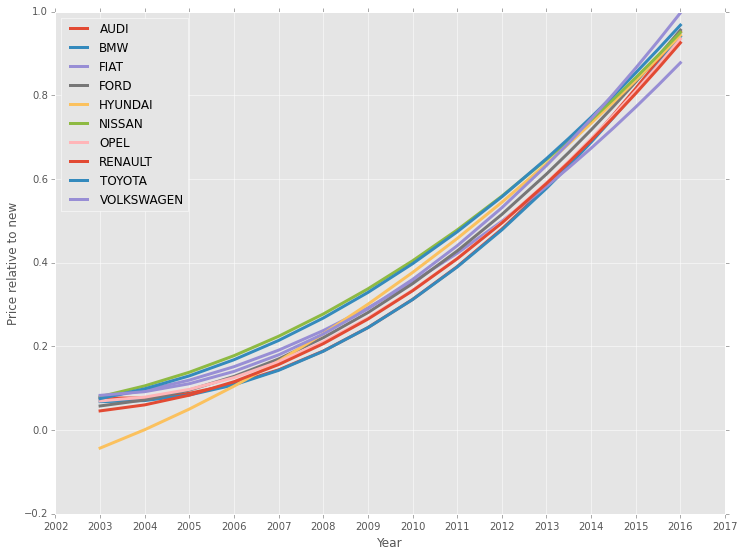

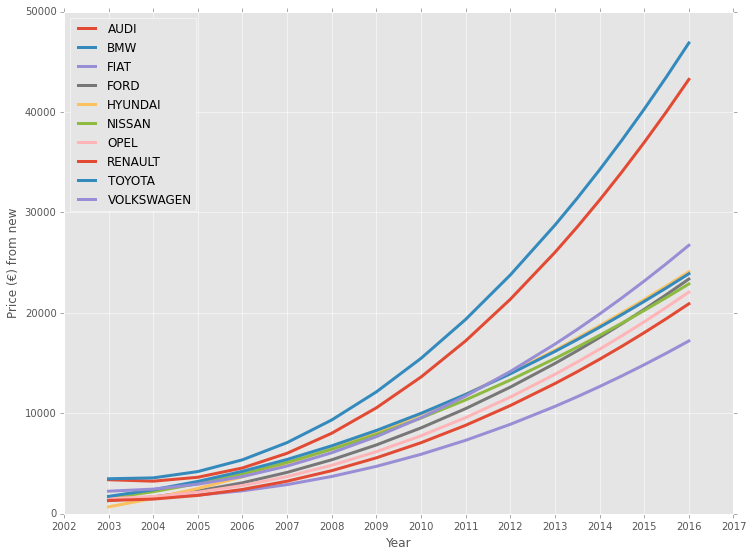

In [13]:

makes = [u'VOLKSWAGEN',
 u'FORD',
 u'TOYOTA',
 u'BMW',
 u'AUDI',
 u'OPEL',
 u'RENAULT',
 u'NISSAN',
 u'FIAT',
 u'HYUNDAI']
def plot_trend(df, field, clusters, relative=True):
    frames = cluster_frame(df, field, clusters, relative)
    trends = [f[['year', 'trendline', field]].drop_duplicates() for f in frames]
    trends = pd.concat(trends)
    data = [{'year': row[1], value: row[2]}
            for value in clusters for row in trends[trends[field] == value].itertuples()
            if row[2] < (2 if relative else 127000)]
    data.sort(key=lambda x: (list(set(x.keys()) - {'year'})[0], x['year']))
    trends = DataFrame(data)
    trends.set_index(['year'], inplace=True)
    plt.rcParams["figure.figsize"] = (12, 9)
    trends.cumsum()
    ax = trends.plot()
    ax.set_xlabel('Year')
    ax.set_ylabel(u'Price %s new' % (u'relative to' if relative else u'(€) from'))
    for line in ax.lines:
        line.set_linewidth(3)
    for leg in ax.legend(loc='best').legendHandles:
        leg.set_linewidth(3)
    ax.set_xticks(range(2002, 2018))
    return trends
_ = plot_trend(df, 'make', makes)
_ = plot_trend(df, 'make', makes, False)

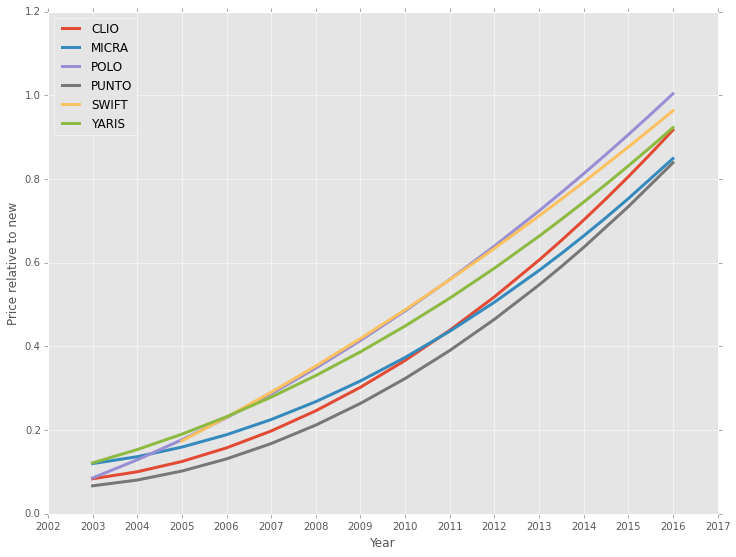

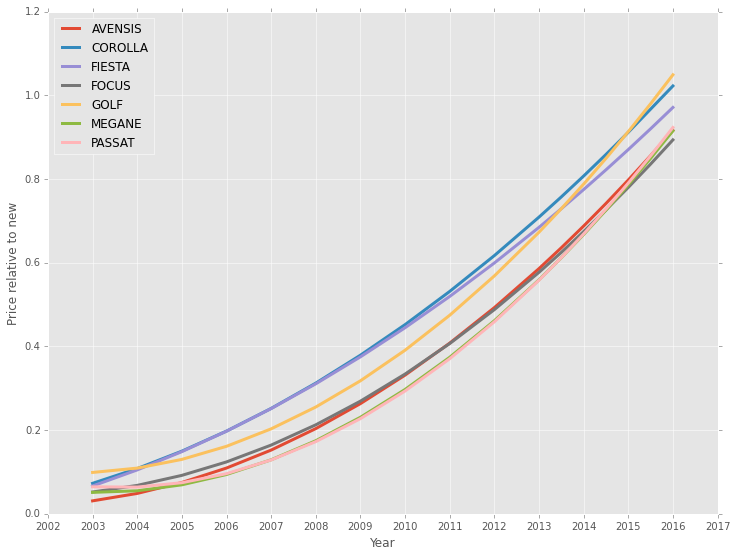

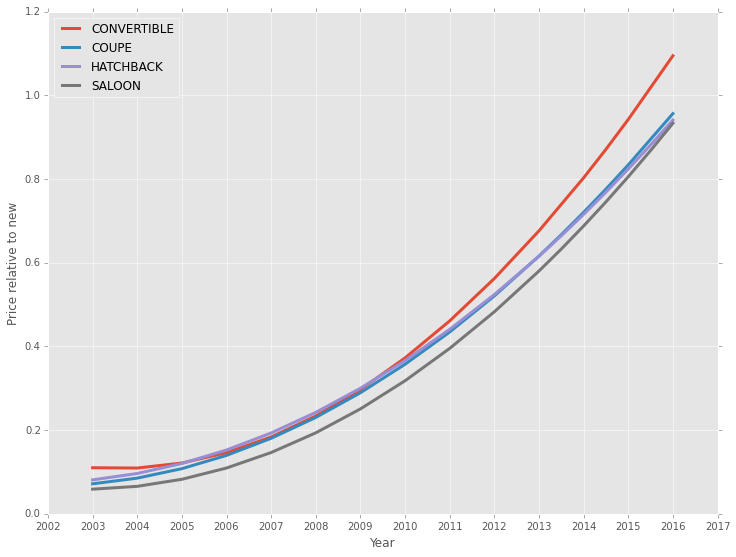

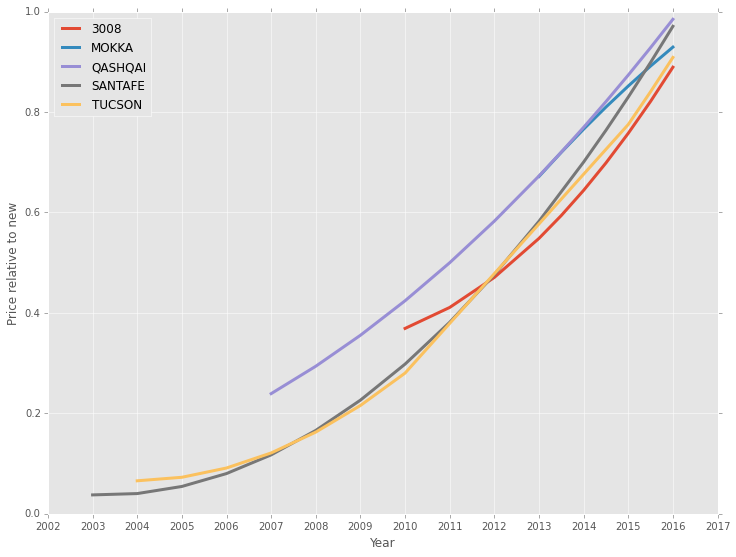

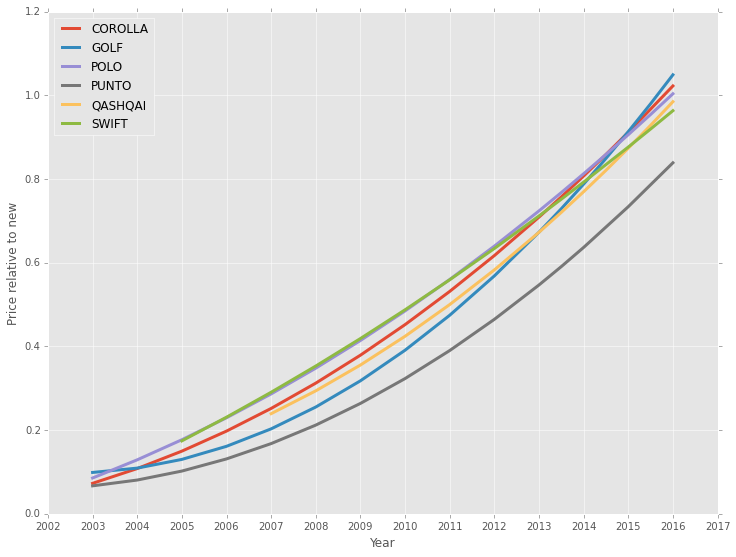

In [14]:
models = ['YARIS', 'POLO', 'PUNTO', 'MICRA', 'CLIO', 'SWIFT']
plot_trend(df, 'model', models)
models = ['GOLF', 'FOCUS', 'PASSAT', 'AVENSIS', 'COROLLA', 'MEGANE', 'FIESTA']
plot_trend(df, 'model', models)
plot_trend(df, 'body', ['HATCHBACK', 'SALOON', 'COUPE', 'CONVERTIBLE'])
models = ['QASHQAI', 'SANTAFE', '3008', 'TUCSON', 'MOKKA']
plot_trend(df, 'model', models)
models = ['QASHQAI', 'SWIFT', 'GOLF', 'PUNTO', 'POLO', 'COROLLA']
_ = plot_trend(df, 'model', models)

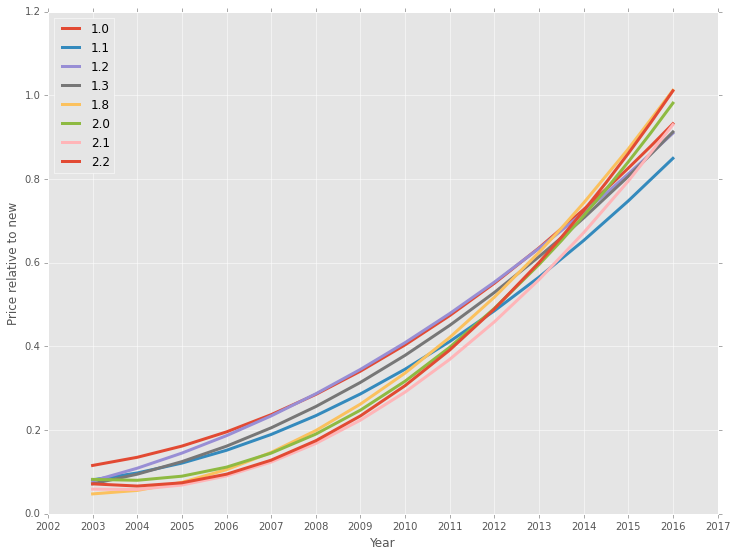

In [15]:
_ = plot_trend(df, 'engine', [1.0, 1.1, 1.2, 1.3, 1.8, 2.0, 2.1, 2.2])

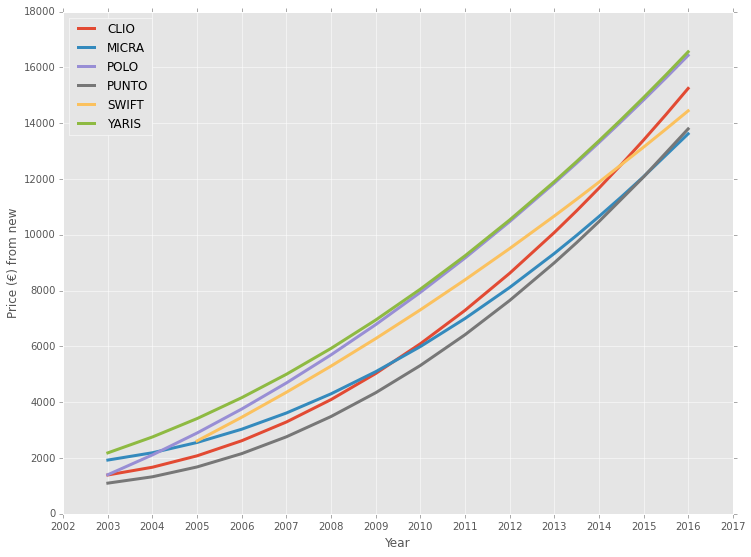

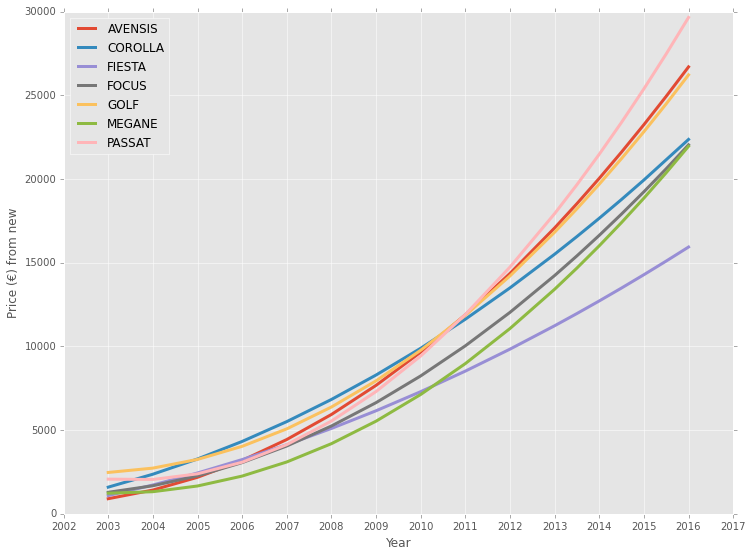

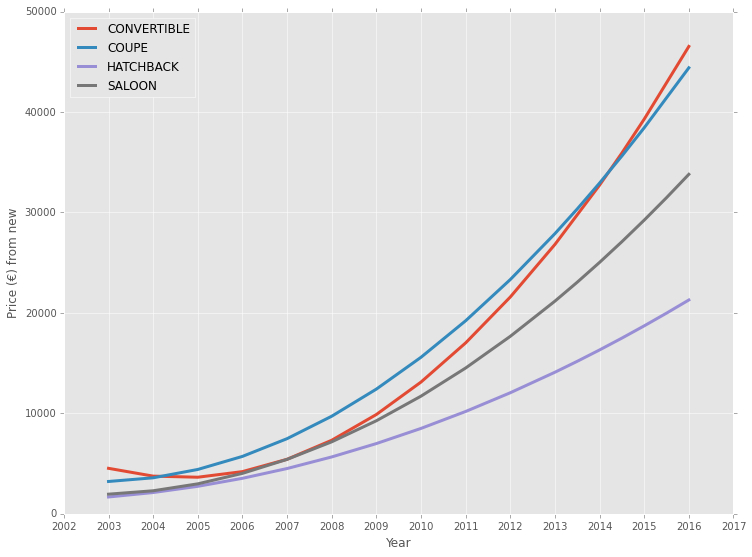

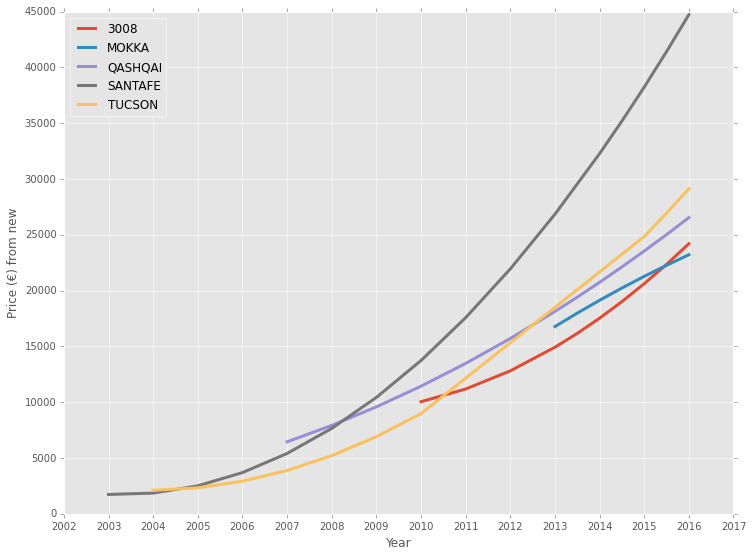

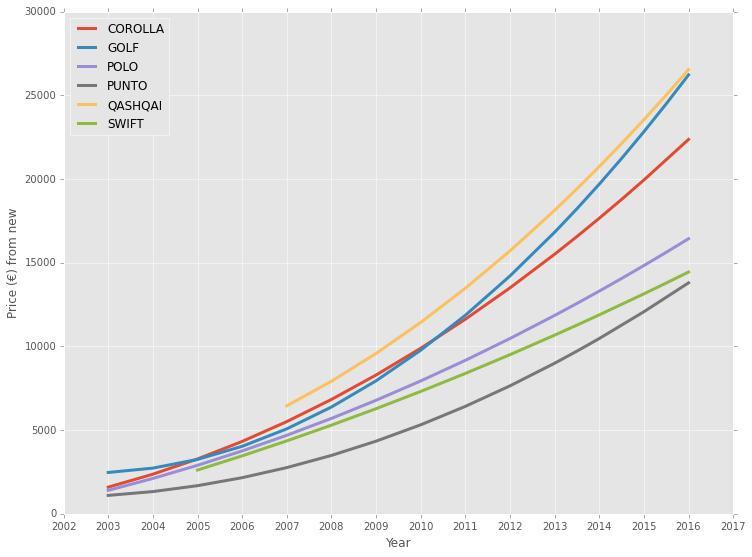

In [16]:
models = ['YARIS', 'POLO', 'PUNTO', 'MICRA', 'CLIO', 'SWIFT']
plot_trend(df, 'model', models, False)
models = ['GOLF', 'FOCUS', 'PASSAT', 'AVENSIS', 'COROLLA', 'MEGANE', 'FIESTA']
plot_trend(df, 'model', models, False)
plot_trend(df, 'body', ['HATCHBACK', 'SALOON', 'COUPE', 'CONVERTIBLE'], False)
models = ['QASHQAI', 'SANTAFE', '3008', 'TUCSON', 'MOKKA']
plot_trend(df, 'model', models, False)
models = ['QASHQAI', 'SWIFT', 'GOLF', 'PUNTO', 'POLO', 'COROLLA']
_ = plot_trend(df, 'model', models, False)